In [1]:
import pandas as pd
import numpy as np
import numpy.core.defchararray as npd
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',1000000)

organ_offers = pd.read_csv("/Users/james/Documents/OneLegacy/organoffers.csv", low_memory = False)


In [11]:
#organs that aren't kidneys
not_k = organ_offers.loc[~(organ_offers.match_organ.isin(['KI', 'KP'])), :]
start = not_k.loc[:, ["donor_id", "datetime_match_run"]]
test1 = start.groupby("donor_id").agg("min")
not_k = not_k.merge(test1, how = "left", on = "donor_id")

In [88]:
not_k['time_2'] = np.floor((pd.to_datetime(not_k['initial_response_datetime']) - pd.to_datetime(not_k['datetime_match_run_x'])).dt.total_seconds()/(3600*5)).astype(int)
not_k['time'] = np.floor((pd.to_datetime(not_k['initial_response_datetime']) - pd.to_datetime(not_k['datetime_match_run_y'])).dt.total_seconds()/(5*3600)).astype(int)

In [178]:
hearts = not_k.loc[not_k.match_organ.isin(['HL', 'HR']), :]
lungs = not_k.loc[not_k.match_organ == 'LU', :]
livers = not_k.loc[not_k.match_organ == 'LI', :]

In [94]:
def get_acceptances(a, string):
    a_times = a.groupby(string)
    max_t = np.max(a[string])
    ratios = []
    for i in range(max_t):
        if (i in a[string].unique()):
            group = a_times.get_group(i)
            acceptances = np.sum(group['offer_accepted']=='Y')
            ratios.append([i, acceptances / len(group)])
    return np.array(ratios)
        
heart_ratios_1 = get_acceptances(hearts, 'time')
lung_ratios_1 = get_acceptances(lungs, 'time')
liver_ratios_1 = get_acceptances(livers, 'time')
heart_ratios_2 = get_acceptances(hearts, 'time_2')
lung_ratios_2 = get_acceptances(lungs, 'time_2')
liver_ratios_2 = get_acceptances(livers, 'time_2')


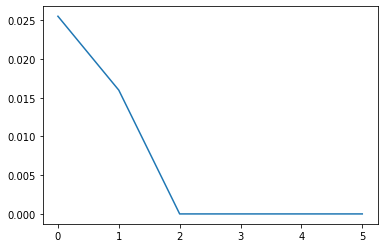

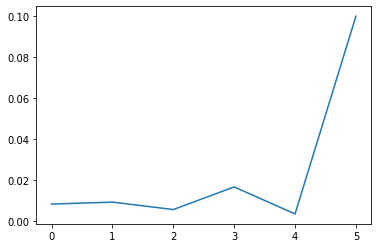

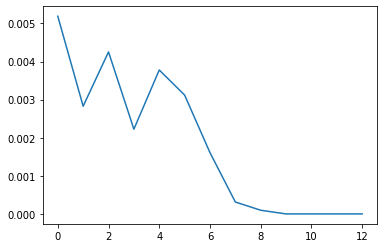

In [95]:
import matplotlib.pyplot as plt

plt.plot(heart_ratios_2[:,0], heart_ratios_2[:, 1])
plt.show()
plt.plot(lung_ratios_2[:,0], lung_ratios_2[:, 1])
plt.show()
plt.plot(liver_ratios_2[:,0], liver_ratios_2[:, 1])
plt.show()

In [96]:
yi_data = pd.read_csv("/Users/james/Documents/OneLegacy/est_data_1h_v2.csv", low_memory = False)

In [187]:
def log_loss(data, times, a, b):
    probs = np.exp(a + b*times) / (1 + np.exp(a + b*times))
    logloss = np.sum(-np.log(probs)*data - (1 - data)*np.log(1 - probs))
    return logloss


In [210]:
#HEARTS SET-UP
hearts_yi = yi_data.loc[yi_data.HR_available == 1, :]
hearts_yi = hearts_yi.reset_index()
flag = [True]
for i in range(1, len(hearts_yi)):
    if(hearts_yi.loc[i, 'HR_allocated']==0 or hearts_yi.loc[i, 'donor_index'] != hearts_yi.loc[i-1, 'donor_index'] or hearts_yi.loc[i, 'HR_allocated'] > hearts_yi.loc[i-1, 'HR_allocated']):
        flag.append(True)
    else:
        flag.append(False)
hearts_yi = hearts_yi.loc[flag, :]
hearts_yi = hearts_yi.reset_index()

#LUNGS SET-UP
lungs_yi = yi_data.loc[yi_data.LU_available > 0, :]
lungs_yi = lungs_yi.reset_index()
flag = [True]
for i in range(1, len(lungs_yi)):
    if(lungs_yi.loc[i, 'LU_allocated']<lungs_yi.loc[i, 'LU_available'] or lungs_yi.loc[i, 'donor_index'] != lungs_yi.loc[i-1, 'donor_index'] or lungs_yi.loc[i, 'LU_allocated'] > lungs_yi.loc[i-1, 'LU_allocated']):
        flag.append(True)
    else:
        flag.append(False)
lungs_yi = lungs_yi.loc[flag, :]
lungs_yi = lungs_yi.reset_index()


#LIVERS SET-UP
livers_yi = yi_data.loc[yi_data.LI_available == 1, :]
livers_yi = livers_yi.reset_index()
flag = [True]
for i in range(1, len(livers_yi)):
    if(livers_yi.loc[i, 'LI_allocated']==0 or livers_yi.loc[i, 'donor_index'] != livers_yi.loc[i-1, 'donor_index'] or livers_yi.loc[i, 'LI_allocated'] > livers_yi.loc[i-1, 'LI_allocated']):
        flag.append(True)
    else:
        flag.append(False)
livers_yi = livers_yi.loc[flag, :]
livers_yi = livers_yi.reset_index()


#HEARTS
hr_alloc = [0]
for i in range(1, hearts_yi.shape[0]):
    if (hearts_yi.loc[i, 'HR_allocated'] == 1):
        hr_alloc.append(1)
    else:
        hr_alloc.append(0)
hr_alloc = np.array(hr_alloc)
print(np.sum(hr_alloc))
hr_times = np.array(hearts_yi['time_in_minutes']/60)

#LUNGS
lu_alloc = [0]
for i in range(1, lungs_yi.shape[0]):
    if (lungs_yi.loc[i-1, 'LU_allocated'] < lungs_yi.loc[i, 'LU_allocated']):
        lu_alloc.append(1)
    else:
        lu_alloc.append(0)
lu_alloc = np.array(lu_alloc)
print(np.sum(lu_alloc))
lu_times = np.array(lungs_yi['time_in_minutes']/60)


def lu_log_loss(x0):
    return log_loss(lu_alloc, lu_times, x0[0], x0[1])


#LIVERS
li_alloc = [0]
for i in range(1, livers_yi.shape[0]):
    if (livers_yi.loc[i, 'LI_allocated'] == 1):
        li_alloc.append(1)
    else:
        li_alloc.append(0)
li_alloc = np.array(li_alloc)
print(np.sum(li_alloc))
li_times = np.array(livers_yi['time_in_minutes']/60)


def li_log_loss(x0):
    return log_loss(li_alloc, li_times, x0[0], x0[1])


105
83
175


In [211]:
import scipy.optimize as sc
res_heart = sc.minimize(hr_log_loss, [-2, 0])
res_lungs  = sc.minimize(lu_log_loss, [-2, 0])
res_livers = sc.minimize(li_log_loss, [-2, 0])

print(res_heart.x, res_lungs.x, res_livers.x)

[-2.19023595 -0.05458496] [-3.51079729 -0.00847394] [-3.03930154 -0.00943406]


In [208]:
lungs_yi = yi_data.loc[yi_data.LU_available == 1, :]
lungs_yi.head()

,donor_index,time_index,cross_clamp,HR_available,LU_available,LI_available,HR_allocated,LU_allocated,LI_allocated,category,total_available,total_allocated,male,age,abo_o,kdpi,pf_ratio,donor_id,time_in_minutes,allocated_organs,available_organs


1791